# Energy Forecasting with NeuralProphet, Darts and MongoDB
## Context and Objectives

<img src="img/smart_grid_data.png" alt="Drawing" style="width: 600px;" align="right"/>

Anticipating energy generation and load request can improve the efficiency of the energy market, since it makes it easier to match the demand with the offer. One of the most common problems in the energy scenario is predicting the amount of generated and requested power over time. 
This is particularly important when dealing with renewable energy sources, such as photovoltaic and eolic, which are heavily charachterized by intermittent production. 


The objective of the present project work is to create a machine-learning prototype pipeline for forecasting solar and eolic generation. There are several requirements that an efficient system should meet, which are not only related to the precision of the model. Since energy production and demand data are constantly generated, an important parameter to consider is the speed of the training phase. In fact, training on a large dataset once is unfeasible, since the environmental conditions affecting these fenomena are constantly changing.

## Tools and Data
In this project we'll focus on two machine-learning based tools, i.e, [NeuralProphet](https://neuralprophet.com/html/index.html) (Triebe *et al.*, 2021) and [Darts](https://unit8co.github.io/darts/index.html) (Herzen *et al.*, 2021). For our purposes, we need two different forecasting tools since Neural Prophet cannot deal with multivariate data, but, differently from Darts, it provides a hybrid model which bridges the gap between interpretable classical methods and scalable deep learning models. 

Data consists of a CSV, provided by [Kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather?select=weather_features.csv), which is described as follows
>This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España.

It comprises several energy sources, some of them renewables while other ones thermal. For our purposes, we will focus only on the solar and wind generation data, with the support of the weather data as a past covariate for eolic generation forecasting. Data has been managed using [MongoDB](https://www.mongodb.com/) (Banker *et al.*, 2016), which is easily integrated with Python and pandas.

## Univariate Forecasting 
<img src="img/neural_prophet.png" align="left" alt="Drawing" style="width: 250px;"/>

NeuralProphet is the successor to Facebook Prophet. Both projects have been developed out of the need to bridge the gap between interpretable classical methods and scalable deep learning models. However, Prophet lacks local context, which is essential for forecasting the near term future and is challenging to extend due to its Stan backend. NeuralProphet is a hybrid forecasting framework based on PyTorch and trained with standard deep learning methods. Local context is introduced with auto-regression and covariate modules, which can be configured as classical linear regression or as Neural Networks [1]. 

In [7]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymongo import MongoClient
from imp import reload

from neuralprophet import NeuralProphet, set_random_seed 

# Settings
set_random_seed(42)
cm = 1/2.54
# reload(plt)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans",
    "font.sans-serif": ["Computer Modern Roman"]})

### Fetching and processing data
<img src="img/mongo.png" align="left" alt="Drawing" style="width: 200px;">

Data is managed using MongoDB, which is well integrated with `pandas`, allowing for an easy manipulation. MongoDB also provides a Python library from which we can call the `MongoClient` for interacting with the collections. 
Energy data needs some processing, given that there are missing data. For this case, we filled the missing data using the *forward fill* method. NeuralProphet needs the timestamp column to be called `ds`, while the target one `y`, so we will proceed to rename them. 

In [8]:
# Read data, remove NaNs and fix columns names
client = MongoClient(port=27017)
energy_data = client.Energy.HourlyGeneration.find()
generation = pd.DataFrame.from_records(energy_data, columns=["time", "generation solar", "generation wind onshore"])

generation.fillna(method="ffill", inplace=True)
#generation.rename(columns={"time": "ds", "generation solar": "y"}, inplace=True)

generation

,time,generation solar,generation wind onshore
0,2014-12-31 23:00:00,49.0,6378.0
1,2015-01-01 00:00:00,50.0,5890.0
2,2015-01-01 01:00:00,50.0,5461.0
3,2015-01-01 02:00:00,50.0,5238.0
4,2015-01-01 03:00:00,42.0,4935.0
...,...,...,...
35059,2018-12-31 18:00:00,85.0,3113.0
35060,2018-12-31 19:00:00,33.0,3288.0
35061,2018-12-31 20:00:00,31.0,3503.0
35062,2018-12-31 21:00:00,31.0,3586.0


 Also, NeuralProphet needs the datastamps to be `datetime` with no UCT, so we convert the `ds` column to the correct type.

In [9]:
# Change dates' datatype as "datetime" (with no UCT)
generation['time'] = pd.to_datetime(generation['time'], utc=True).dt.tz_localize(None)

generation.set_index(keys=["time"], inplace=True)

Data has a span of 4 years, but we will focus only on the first 6 months of 2017. In fact, sometimes a larger time series affects the performance of the forecasting model negatively, other than adding more computational burden. 

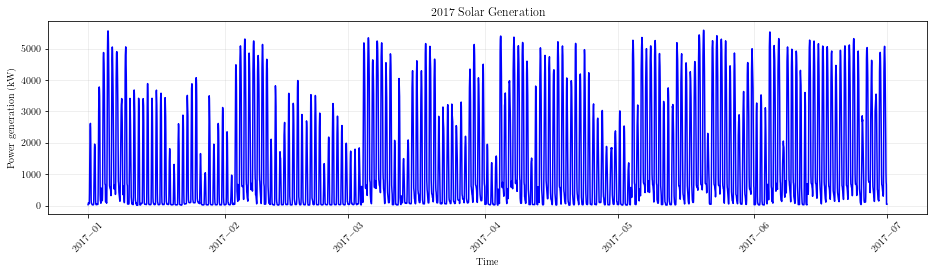

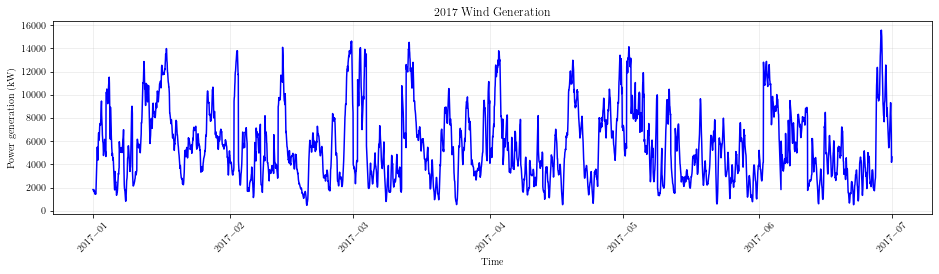

In [10]:
# Solar generation in 2017
interval_start = "2017-01-01 00:00:00"
interval_end   = "2017-07-01 00:00:00"
generation_2017 = generation[interval_start:interval_end]

data = {
    "solar": {"title": "$2017$ Solar Generation", 
              "data": generation_2017[["generation solar"]],
              "target": "generation solar"},
    "wind": {"title": "$2017$ Wind Generation",
             "data": generation_2017[["generation wind onshore"]],
             "target": "generation wind onshore"}
}

for value in data.values(): 
    fig_2017_generation = plt.figure(figsize=(40*cm, 9*cm))
    plt.grid(True, alpha=0.25)
    plt.plot(value["data"], color="b")
    plt.title(value["title"])
    plt.xlabel("Time")
    plt.ylabel("Power generation (kW)")
    plt.xticks(rotation=45)
    plt.show()

### Apply log-transformation to data 
It is well-known that log-transformation improves the overall results of forecasting algorithms, given that, in time series analysis, this transformation stabilizes the variance of a series (Lütkepohl *et al.*, 2012).

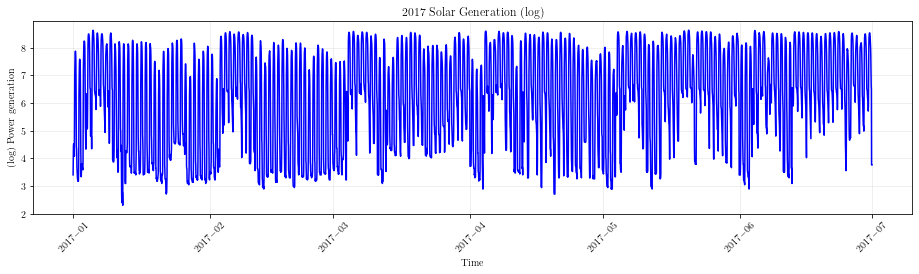

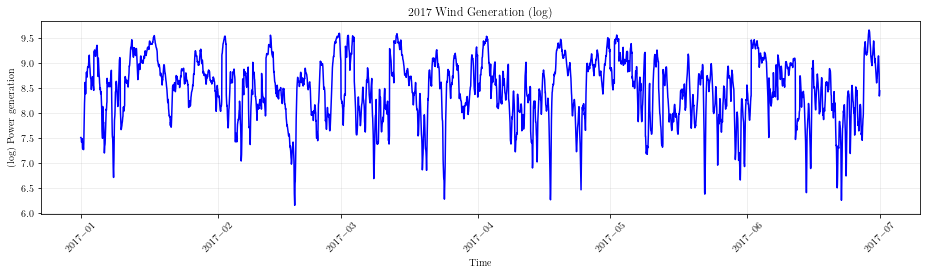

In [11]:
# log Solar generation in 2017
data["solar"]["proc_data"] = data["solar"]["data"][["generation solar"]].apply(np.log)
data["wind"]["proc_data"] = data["wind"]["data"][["generation wind onshore"]].apply(np.log)

for value in data.values(): 
    fig_2017_generation = plt.figure(figsize=(40*cm, 9*cm))
    plt.grid(True, alpha=0.25)
    plt.plot(value["proc_data"], color="b")
    plt.title(f"{value['title']} (log)")
    plt.xlabel("Time")
    plt.ylabel("(log) Power generation")
    plt.xticks(rotation=45)
    plt.show()

### Training the model and forecasting
We train the model with a forecasting window of 24 hours, i.e., the day-ahead window. Tuning the hyperparameters is tricky: `n_lags` determines how far into the past the auto-regressive dependencies should be considered, while the `weekly_seasonality` makes the model look for seasonalities on a weekly basis. The validation set corresponds to $30\%$ of the six-month period.

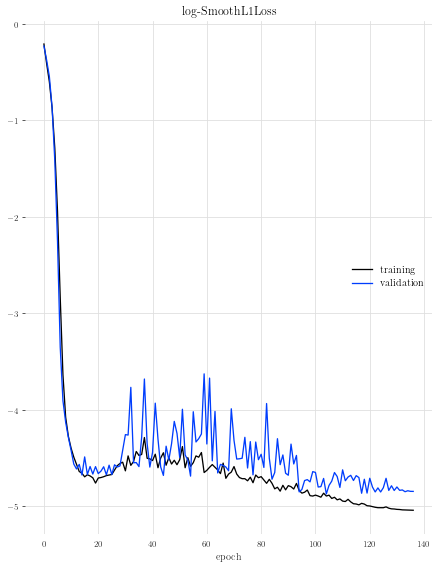

Epoch[137/137]: 100%|█| 137/137 [00:50<00:00,  2.70it/s, SmoothL1Loss=0.00648, MAE=0.514, RMSE=0.697, RegLoss=0, MAE_va


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
136,0.00648,0.513772,0.697065,0.0,0.007879,0.561398,0.770194


In [17]:
# Training and Forecast Solar Generation (24 hours)
solar_model = NeuralProphet(n_forecasts=24,
                            n_lags=48,
                            weekly_seasonality=True)

data["solar"]["proc_data"].reset_index(level="time", inplace=True)
data["solar"]["proc_data"].rename(columns={"time": "ds", data["solar"]["target"]: "y"}, inplace=True)

train, test = solar_model.split_df(data["solar"]["proc_data"], valid_p=0.3, freq="h")
metrics = solar_model.fit(train, validation_df=test,  freq="h", plot_live_loss=True)

data["solar"]["model"] = solar_model

metrics.tail(1)

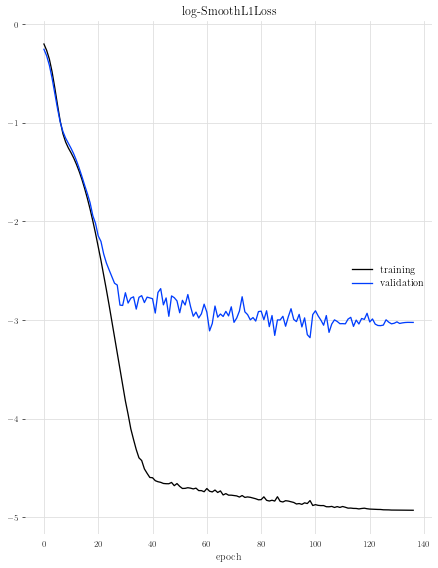

Epoch[137/137]: 100%|█| 137/137 [01:00<00:00,  2.25it/s, SmoothL1Loss=0.00722, MAE=0.289, RMSE=0.39, RegLoss=0, MAE_val


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
136,0.007224,0.289203,0.390305,0.0,0.048525,0.879514,1.002501


In [18]:
# Training and Forecast Wind Generation (24 hours)
wind_model = NeuralProphet(n_forecasts=24,
                           n_lags=48,
                           num_hidden_layers=2,
                           weekly_seasonality=True)

data["wind"]["proc_data"].reset_index(level="time", inplace=True)
data["wind"]["proc_data"].rename(columns={"time": "ds", data["wind"]["target"]: "y"}, inplace=True)

train, test = wind_model.split_df(data["wind"]["proc_data"], valid_p=0.3, freq="h")
metrics = wind_model.fit(train, validation_df=test,  freq="h", plot_live_loss=True)

data["wind"]["model"] = wind_model

metrics.tail(1)

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


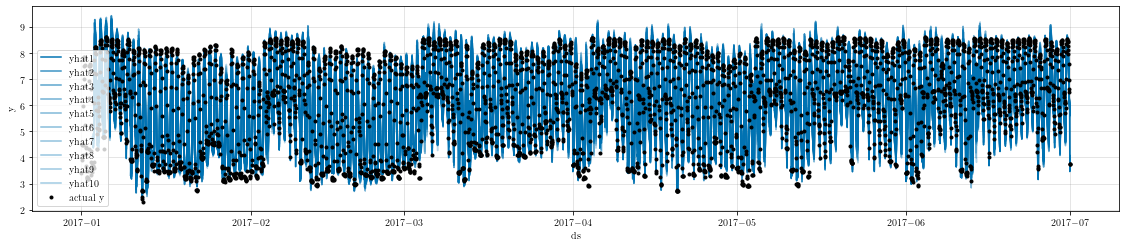

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


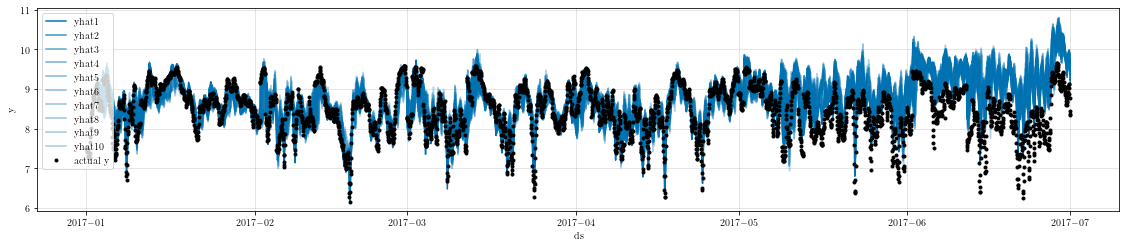

In [24]:
for value in data.values():
    value["forecast"] = value["model"].predict(value["proc_data"])
    value["model"].plot(value["forecast"], figsize=(40*cm, 9*cm))
    plt.show()

It is evident how simple univariate forecasting performs poorly, since wind data, differently from solar, doesn't have a strong seasonality.  

### Forecasting components (*solar generation*)
In the following, we report the components of the forecasted curve. The trend curve has an explainable decreasing shape for January and February. Notice how the trend curve becomes almost flat after the beginning of March. This may be due to contingential weather conditions occurred in Spain during 2017. The daily trend, instead, seems to be correct, since it has a higher plateau during the middle of the day, when the sun provides the most irradiance.

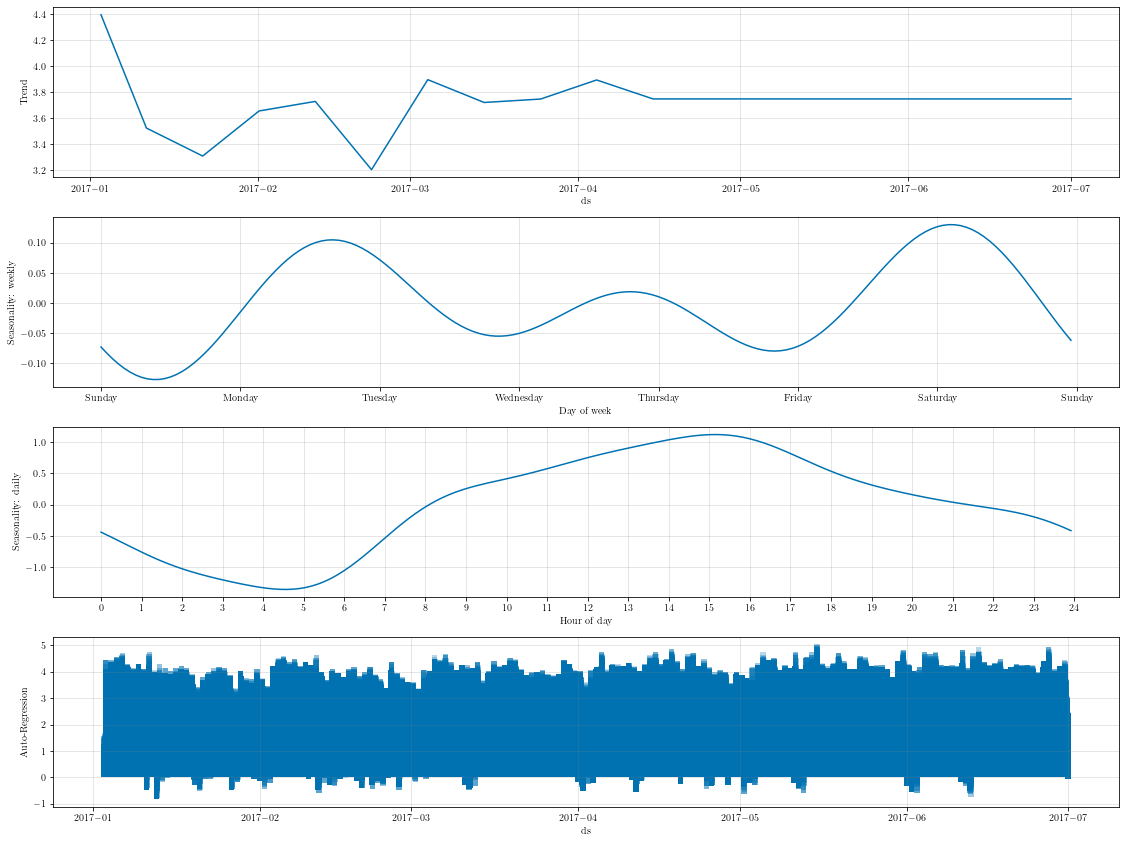

In [56]:
m.plot_components(data["solar"]["log_forecast"], figsize=(40*cm, 30*cm))
plt.show()

## Covariate Multivariate Forecasting 
<img src="img/darts.png" align="left" style="width: 250px;"/>

Darts offers a variety of models, from classics such as ARIMA to state-of-the-art deep neural networks. The emphasis of the library is on offering modern machine learning functionalities, such as supporting multidimensional series, meta-learning on multiple series, training on large datasets, incorporating external data, ensembling models, and providing rich support for probabilistic forecasting. The need for Darts comes from NeuralProphet lack of multivariate capabilities, which will prove essential to improve the quality of wind energy forecasting.

<!-- Darts offers a variety of models, from classics such as ARIMA to state-of-the-art deep neural networks. The emphasis of the library is on offering modern machine learning functionalities, such as supporting multidimensional series, meta-learning on multiple series, training on large datasets, incorporating external data, ensembling models, and providing a rich support for probabilistic forecasting [2]. The need for Darts come for the NeuralProphet lack of multivariate forecasting capabilities, which will prove essential to improve the wind forecasting quality. -->

In [19]:
import torch

from darts import TimeSeries
from darts.utils.model_selection import train_test_split
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler

from darts.metrics import mae

# Random seeds
torch.manual_seed(22)
np.random.seed(22)

### Pulling and processing weather data 
Weather data, collected from OpenWeatherMap contains several fields, of which only `windSpeed` and `windDeg` will be used. Of course, one could try to integrate more attributes, but it will inevitably slow the training phase. Wind information will be used as past covariates for the wind generation curve.

In [20]:
columns = [
    "time", "city",
    "windSpeed", "windDeg"
]

# Change back the datetime index from "ds" to "time"
data["wind"]["proc_data"].rename(columns={"ds": "time"}, inplace=True)
data["wind"]["proc_data"].set_index("time", inplace=True)
series_wind = TimeSeries.from_dataframe(data["wind"]["proc_data"], freq="h")

# Pull the weather collection from Mongo and set timedate datatype
weather_data = client.Energy.HourlyWeather.find()
weather_df = pd.DataFrame.from_records(weather_data, columns=columns)
weather_df["time"] = pd.to_datetime(weather_df['time'], utc=True).dt.tz_localize(None)
weather_df.set_index(keys=["time", "city"], inplace=True)

# Remove duplicate timedates
weather_df = weather_df[~weather_df.index.duplicated(keep='first')]

In [21]:
weather_df = weather_df.query(f'"{interval_start}" <= time <= "{interval_end}"')
weather_df

,,windSpeed,windDeg
time,city,,
2017-01-01 00:00:00,Valencia,0,0
2017-01-01 01:00:00,Valencia,1,0
2017-01-01 02:00:00,Valencia,1,0
2017-01-01 03:00:00,Valencia,1,0
2017-01-01 04:00:00,Valencia,2,260
...,...,...,...
2017-06-30 20:00:00,Seville,2,350
2017-06-30 21:00:00,Seville,1,330
2017-06-30 22:00:00,Seville,4,337


In [22]:
# Extract the cities list
cities = weather_df.index.get_level_values("city").unique().tolist()
cities

['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville']

Weather data is related to different Spanish cities. Since we have the aggregate amount of wind energy produced, we will use the `windSpeed` and `windDeg` of each city, creating one field for each attribute.

In [23]:
weather_cov_df = pd.DataFrame({"time": pd.date_range(interval_start, interval_end, freq="h")}) \
                             .set_index("time")
for city in cities:
    weather_city_df = weather_df.query(f"city=='{city}'") \
                                .reset_index(level="city", drop=True) \
                                .rename(columns={"windSpeed": f"windSpeed{city}", 
                                                 "windDeg": f"windDeg{city}"})
    weather_cov_df = weather_cov_df.join(weather_city_df, how="left")
    
weather_cov_df

,windSpeedValencia,windDegValencia,windSpeedMadrid,windDegMadrid,windSpeedBilbao,windDegBilbao,windSpeed Barcelona,windDeg Barcelona,windSpeedSeville,windDegSeville
time,,,,,,,,,,
2017-01-01 00:00:00,0,0,1,350,1,178,5,260,2,28
2017-01-01 01:00:00,1,0,1,340,0,0,5,260,2,28
2017-01-01 02:00:00,1,0,1,340,1,175,5,260,2,31
2017-01-01 03:00:00,1,0,1,0,1,175,5,260,2,31
2017-01-01 04:00:00,2,260,1,350,1,175,5,260,0,20
...,...,...,...,...,...,...,...,...,...,...
2017-06-30 20:00:00,4,60,3,330,3,270,4,60,2,350
2017-06-30 21:00:00,4,100,6,280,4,290,4,40,1,330
2017-06-30 22:00:00,2,360,3,320,3,270,1,40,4,337


We can now transform the `Dataframe` into a `TimeSeries`, which is the Darts main class.

In [270]:
weather_cov_ts = TimeSeries.from_dataframe(weather_cov_df, freq="h")

In [271]:
# Split target and covariates in train and test data
series_wind_train, series_wind_test = train_test_split(series_wind, test_size=0.3)
weather_cov_ts_train, weather_cov_ts_test = train_test_split(weather_cov_ts, test_size=0.3)

### Training the model and forecasting
The selected model is the `BlockRNNModel`, which is a Recursive Neural Network with LSTM nodes. It is one of the models which allow for both covariate and multivariate forecasting.

In [272]:
model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=300,
    random_state=22,
)

model.fit(series=series_wind_train, 
          past_covariates=weather_cov_ts_train, 
          verbose=True)

today = datetime.now().strftime("%d-%m-%YT%H-%M-%S")
model.save_model(f"model/{today}.pth.tar")

[2022-03-11 19:14:57,605] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3007 samples.
[2022-03-11 19:14:57,605] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3007 samples.
[2022-03-11 19:14:57,609] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-11 19:14:57,609] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/300 [00:00<?, ?it/s]

Given the resulting model, we can use it to evaluate the historical forecasts that would have been obtained by this model on the `series`. The metric used is MAE, as it did for the univariate case.

MAE = 0.4804


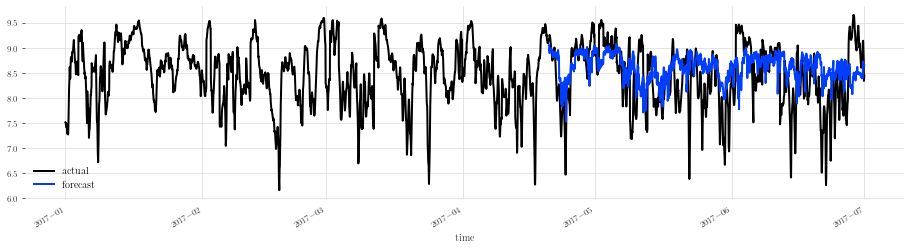

In [282]:
series_wind_back = model.historical_forecasts(
    series=series_wind, 
    past_covariates=weather_cov_ts,
    retrain=False,
    start=0.6,
    forecast_horizon=24,
    verbose=True)

fig = plt.figure(figsize=(40*cm, 9*cm))
series_wind.plot(label="actual")
series_wind_back.plot(label="forecast", alpha=0.1)

print(f"Validation MAE = {round(mae(series_wind, series_wind_back),4)}")

It can be seen that the performance of the `BlockRNNModel`, with multivarate past covariates, outperforms NeuralProphet: the former has a MAE of $0.4804$, while the latter is $0.768$.

## Conclusions and Future Work
<img src="img/future_works.png" align="left" style="width: 700px;"/>

The objective of this project work was to create the preliminary basis for a forecasting tool for renewable energy generation.
This project gives a glimpse of the difficulties of predicting curves that do not have inherent seasonality patterns, such as wind generation. 
Future work would focus on deploying a pipeline for pulling data, regarding energy and weather, in order to build a renewable energy forecasting tool. Important features that can also be considered are the aggregate or local load and energy price.

<img src="img/serra_giannina.png" align="left" style="width: 400px;"/>

In particular, several open-source tools, other than MongoDB, have been developed for timeseries management, such as [InfluxDB](https://www.influxdata.com/) and its plugin [Telegraph](https://www.influxdata.com/time-series-platform/telegraf/).
The following is a custom [TOML](https://github.com/toml-lang/toml) configuration file used to pull data from OpenWeather. In particular, the current latitude and longitude coordinates target the "Serra Giannina" eolic plant, which is located in Apulia, near Melfi. This is being used in place of the default Telegraph OpenWeather `.conf` file, since the latter is too simplistic.

## References 
Triebe, Oskar, et al. "NeuralProphet: Explainable Forecasting at Scale." arXiv preprint arXiv:2111.15397 (2021). 

Herzen, Julien, et al. "Darts: User-friendly modern machine learning for time series." arXiv preprint arXiv:2110.03224 (2021).

Banker, Kyle, et al. MongoDB in Action: Covers MongoDB version 3.0. Simon and Schuster, 2016.

Lütkepohl, Helmut, and Fang Xu. "The role of the log transformation in forecasting economic variables." Empirical Economics 42.3 (2012): 619-638.